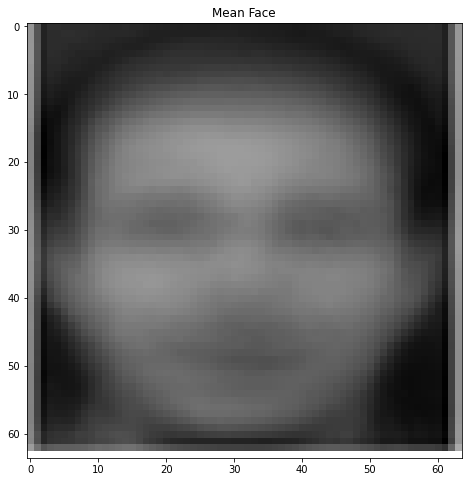

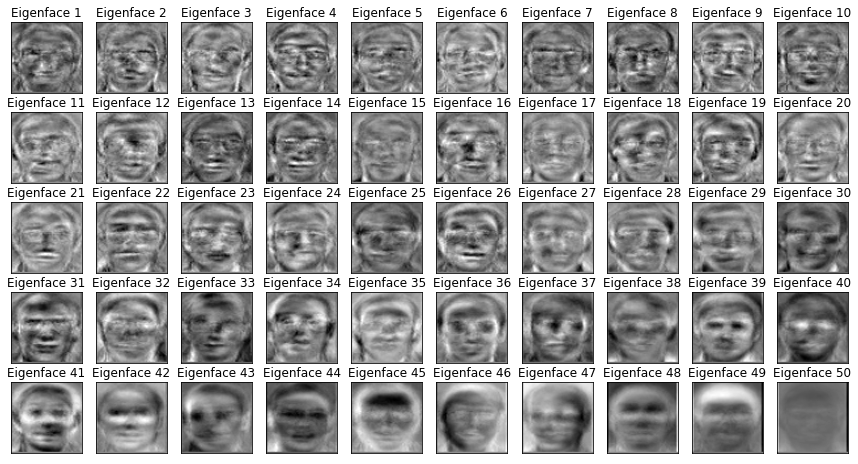

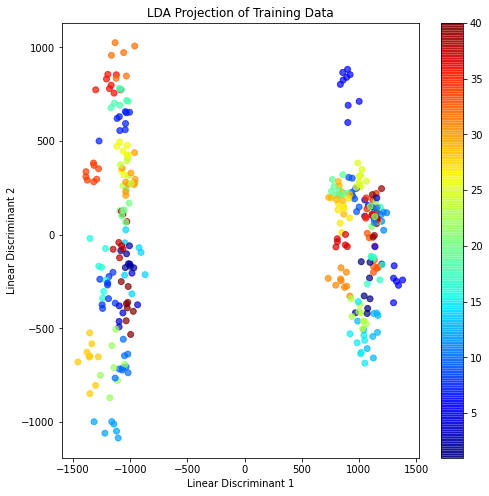

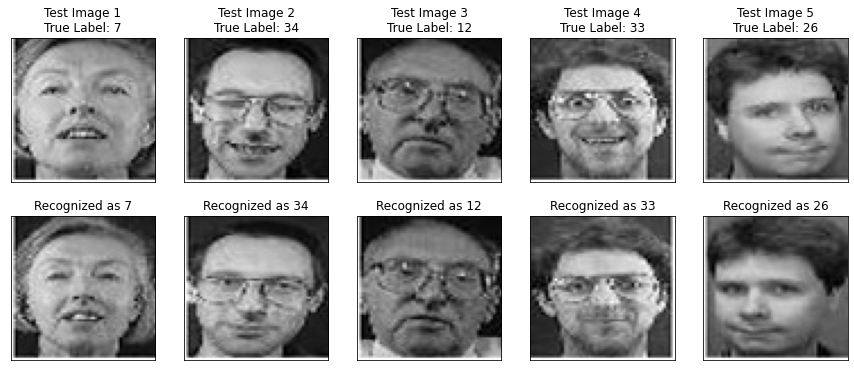

Accuracy: 0.99


In [3]:
import numpy as np
import os
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L').resize((64, 64))  # 转换为灰度图并调整大小
            img_array = np.array(img).flatten()  # 展开为一维向量
            person_id = int(re.split(r'[_.]', filename)[0])
            images.append(img_array)
            labels.append(person_id)
    return np.array(images), np.array(labels)

# 加载数据
X, y = load_images_from_folder('data')

# 将数据划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# 计算平均脸
mean_face = np.mean(X_train, axis=0)

# 去均值人脸
X_train_centered = X_train - mean_face

# 计算 X.T * X
cov_matrix = np.dot(X_train_centered.T, X_train_centered)

# 计算特征值和特征向量
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# 选择前 k 个特征向量
k_pca = 50
top_eigenvectors = eigenvectors[:, -k_pca:]

# PCA降维
X_train_pca = np.dot(X_train_centered, top_eigenvectors)

# 计算类内均值向量
mean_vectors = []
for cl in np.unique(y_train):
    mean_vectors.append(np.mean(X_train_pca[y_train == cl], axis=0))

# 计算散布矩阵
S_W = np.zeros((k_pca, k_pca))
for cl, mv in zip(np.unique(y_train), mean_vectors):
    class_scatter = np.zeros((k_pca, k_pca))  # 类内散布矩阵
    for row in X_train_pca[y_train == cl]:
        row, mv = row.reshape(k_pca, 1), mv.reshape(k_pca, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

overall_mean = np.mean(X_train_pca, axis=0)
S_B = np.zeros((k_pca, k_pca))  # 类间散布矩阵
for i, mean_vec in enumerate(mean_vectors):
    n = X_train_pca[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(k_pca, 1)
    overall_mean = overall_mean.reshape(k_pca, 1)
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

# 计算散布矩阵的特征值和特征向量
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

# 选择前 k 个特征向量
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
top_eig_vecs = np.array([eig_pairs[i][1] for i in range(k_pca)]).T.real

# 投影到特征空间
X_train_lda = X_train_pca.dot(top_eig_vecs)

# 输入新图片进行测试并计算坐标
def project_face(face_vector):
    face_centered = face_vector - mean_face
    face_pca = face_centered.dot(top_eigenvectors)
    return face_pca.dot(top_eig_vecs)

def recognize_face(test_face):
    test_face_lda = project_face(test_face)
    similarities = cosine_similarity(X_train_lda, [test_face_lda])
    most_similar_index = np.argmax(similarities)
    return y_train[most_similar_index]

# 可视化 1：平均脸
plt.figure(figsize=(8, 8))
plt.imshow(mean_face.reshape(64, 64), cmap='gray')
plt.title("Mean Face")
plt.show()

# 可视化 2：前几个特征脸 (Top Eigenfaces)
eigenfaces = top_eigenvectors.T.reshape((k_pca, 64, 64))
fig, axes = plt.subplots(5, 10, figsize=(15, 8), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
plt.show()

# 可视化 3：降维后的数据分布 (LDA Projection)
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train, cmap='jet', alpha=0.7)
plt.colorbar(scatter)
plt.title("LDA Projection of Training Data")
plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.show()

# 可视化 4：测试图片与识别结果对比 (Test Image vs. Recognized Image)
def visualize_test_results(X_test, y_test, mean_face, top_eigenvectors, top_eig_vecs, X_train_lda, y_train):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6), subplot_kw={'xticks':[], 'yticks':[]})
    for i in range(5):
        test_face = X_test[i]
        prediction = recognize_face(test_face)
        
        # 显示测试图片
        axes[0, i].imshow(test_face.reshape(64, 64), cmap='gray')
        axes[0, i].set_title(f"Test Image {i+1}\nTrue Label: {y_test[i]}")
        
        # 显示识别出的最相似训练图片
        most_similar_train_face = X_train[np.where(y_train == prediction)[0][0]]
        axes[1, i].imshow(most_similar_train_face.reshape(64, 64), cmap='gray')
        axes[1, i].set_title(f"Recognized as {prediction}")
    
    plt.show()

# 调用函数显示测试结果对比
visualize_test_results(X_test, y_test, mean_face, top_eigenvectors, top_eig_vecs, X_train_lda, y_train)

# 测试模型准确性
correct = 0
for i, test_face in enumerate(X_test):
    prediction = recognize_face(test_face)
    if prediction == y_test[i]:
        correct += 1

accuracy = correct / len(X_test)
print(f"Accuracy: {accuracy:.2f}")
